In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble

pandas.set_option("display.precision", 2)

datafile = '../../Data/Raw/airbnb/airbnb_queens_2019.csv'

model_name = 'Random Forest'

target_outlier = True
feature_outlier= True
feature_norm   = True
target_norm    = False

target_variable = ['price']

info_variables = ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group','last_review',]
# categorical_variables = ['room_type','neighbourhood',]
categorical_variables = []

numeric_variables = ['latitude', 'longitude', 'minimum_nights','number_of_reviews', 
                     'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [2]:
%run functions.ipynb

# Load Data 

In [3]:
data = pandas.read_csv(datafile, sep=',')
print(data.shape)
print(data.columns)
data.head()

(5666, 16)
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,12937,"1 Stop fr. Manhattan! Private Suite,Landmark B...",50124,Orestes,Queens,Long Island City,40.75,-73.95,Private room,130,3,248,01-07-19,2.25,1,215
1,18198,Little King of Queens,70091,Justin,Queens,Woodside,40.75,-73.90,Private room,70,30,25,31-05-19,0.22,1,324
2,32363,Fully Furnished Basement Apartment,140025,Fredah,Queens,Flushing,40.74,-73.83,Private room,140,2,1,19-09-11,0.01,1,1
3,39593,"A room w/ a Manhattan view, longer stay",110506,Myung,Queens,Sunnyside,40.75,-73.92,Private room,79,30,28,12-04-19,0.26,1,126
4,45910,Beautiful Queens Brownstone! - 5BR,204539,Mark,Queens,Ridgewood,40.70,-73.90,Entire home/apt,350,8,10,12-05-19,0.11,5,365


# Outlier 

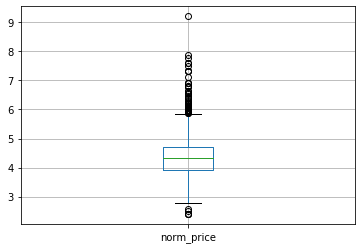

In [4]:
data['norm_price'] = np.log1p(data[target_variable])
data.boxplot('norm_price')

In [5]:
if target_outlier:
    print('data before:', data.shape)
    data = data[(data.norm_price>3) & (data.norm_price<6)].copy()
    print('data after:', data.shape)
    data.drop('norm_price', axis=1, inplace=True)

data before: (5666, 17)
data after: (5601, 17)


# Preencher Valores Nulos

In [6]:
for cname in ['number_of_reviews', 'reviews_per_month']:
    data[cname].fillna(0, inplace=True)

# Normalização de Variáveis

In [7]:
if feature_norm:
    log_norm_cols = ['minimum_nights', 'number_of_reviews', 
                     'reviews_per_month', 'calculated_host_listings_count','availability_365']

    data[log_norm_cols] = preprocessing.power_transform(data[log_norm_cols], method='yeo-johnson')

# Remoção Outlier Variáveis

In [8]:
if feature_outlier:
    for cname in numeric_variables:
        lo_lim = np.quantile(data[cname], 0.10)
        up_lim = np.quantile(data[cname], 0.90)
        data.loc[data[cname] < lo_lim, cname] = lo_lim
        data.loc[data[cname] > up_lim, cname] = up_lim

# Normalizando o Alvo 

In [9]:
if target_norm:
    data[target_variable] = np.log1p(data[target_variable])

# Codificando Variaveis 

In [10]:
if len(categorical_variables):
    cat_data = pandas.get_dummies(data[categorical_variables])
    train_data = pandas.concat((data.drop(categorical_variables,axis=1), cat_data), axis=1, sort=False)
    train_data.drop(info_variables, axis=1, inplace=True)
else:
    train_data = data[numeric_variables+target_variable]

# Validação Cruzada 

In [11]:
# Train Pipeline
X = train_data.drop(target_variable, axis=1).values
Y = train_data[target_variable].values

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y.reshape(-1),
                                                                test_size=0.2,
                                                                random_state=0)

# Objeto de validacao cruzada
cvfold = model_selection.KFold(n_splits = 10, random_state = 0)

# Curvas de Aprendizado 

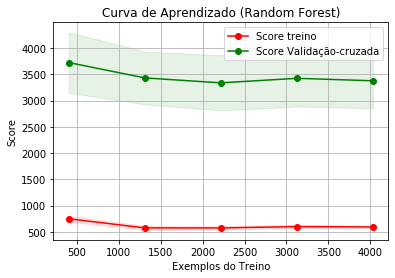

In [14]:
plt.figure()

scorer = metrics.make_scorer(metrics.mean_squared_error)

title = "Curva de Aprendizado (%s)"%model_name
estimator = ensemble.RandomForestRegressor(n_estimators=10)
plot_learning_curve(estimator, title, Xtrain, Ytrain, ax=plt.gca(),
                    cv=cvfold, scoring=scorer, n_jobs=1)


# Curvas de Validação de Parâmetros  

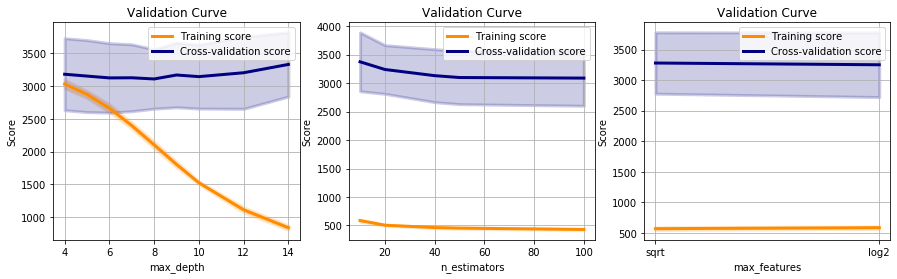

In [17]:

plt.figure(figsize=(15,4))

param_name_list = ['max_depth','n_estimators','max_features']
param_range_list = [
    [4,5,6,7,8,9,10, 12, 14],
    [10, 20 ,40, 50, 100],
    ['sqrt','log2']
]


scorer = metrics.make_scorer(metrics.mean_squared_error)
for i, (param_name, param_range) in enumerate(zip(param_name_list, param_range_list)):
    plt.subplot(1,3,i+1)
    plot_validation_curve(ensemble.RandomForestRegressor(n_estimators=10),
                          param_name=param_name,
                          param_range=param_range,
                          X = Xtrain,
                          Y = Ytrain,
                          cv=cvfold,
                          scoring = scorer,
                          n_jobs=1,
                          ax=plt.gca())


# Pipeline de Treinamento 

In [19]:
# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', ensemble.RandomForestRegressor()),
]

# Create Pipeline
model_pipe = pipeline.Pipeline(conf_train_pipe)

param_grid = {
    'Model__max_depth': [4,5,6,7,8,9,10],
    'Model__n_estimators' : [10, 20, 40, 50, 100],
    'Model__max_features' : ['sqrt','log2'],
}

scorer = metrics.make_scorer(metrics.mean_squared_log_error)
model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                     scoring=scorer,
                                     fit_params=None,
                                     cv=cvfold,
                                     return_train_score=True)

model_pipe.fit(Xtrain, Ytrain)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_s...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'Model__max_depth': [4, 5, 6, 7, 8, 9, 10], 'Model__n_estimators': [10, 20, 40, 50, 100], 'Model__max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_log_error), verbose=0)

## Estimativa do Modelo 

In [20]:
Yhat = model_pipe.predict(Xtest)

if target_norm:
    Yhat = np.expm1(Yhat)
    Ytest = np.expm1(Ytest)
else:
    Yhat[Yhat<0] = 0


print('Yhat.shape:', Yhat.shape)

Yhat.shape: (1121,)


# Scores Validacao Cruzada 

In [21]:
print('Train')
print('\tScore:', np.mean(model_pipe.cv_results_['mean_train_score']),
       '+-'     , np.mean(model_pipe.cv_results_['std_train_score']))
print('Test')
print('\tScore:', np.mean(model_pipe.cv_results_['mean_test_score']),
       '+-'     , np.mean(model_pipe.cv_results_['std_test_score']))

Train
	Score: 0.21699146327162844 +- 0.0027202293262214216
Test
	Score: 0.2631190933319063 +- 0.016114032643167284


# Distribuições 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


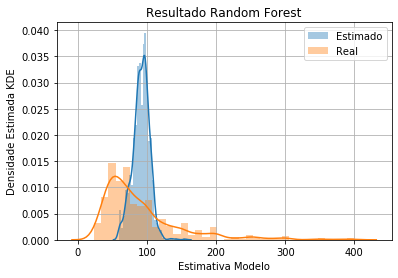

In [22]:
plt.figure()
# idx = Y < 1000
sns.distplot(Yhat, label='Estimado')
sns.distplot(Ytest, label='Real')
plt.title('Resultado ' + model_name)
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Estimativa Modelo')
plt.grid()
plt.legend()

# Scatter Plot 

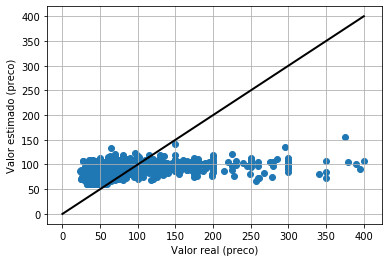

In [23]:
plt.figure()

plt.plot([0, Ytest.max()], [0, Ytest.max()], '-k',lw=2,label='Linha Ideal')
plt.scatter(Ytest, Yhat)
plt.xlabel('Valor real (preco)')
plt.ylabel('Valor estimado (preco)')
plt.grid()

# Plot de Resíduo 

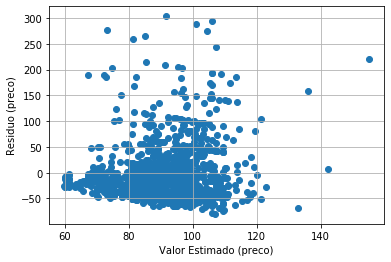

In [24]:
plt.figure()
plt.scatter(Yhat, Ytest - Yhat)
plt.xlabel('Valor Estimado (preco)')
plt.ylabel('Residuo (preco)')
plt.grid()

# Metrics

In [25]:
def mape(y, yhat):
    idx = y != 0
    return np.mean(np.abs((y[idx]-yhat[idx])/ y[idx])) * 100


print('r2  :', metrics.r2_score(Ytest, Yhat))
print('mse :', metrics.mean_squared_error(Ytest, Yhat))
print('msle:', metrics.mean_squared_log_error(Ytest, Yhat))
print('mae :', metrics.mean_absolute_error(Ytest, Yhat))
print('mape:', mape(Ytest, Yhat))



r2  : 0.08746922437280424
mse : 3042.812819394839
msle: 0.27006729614744773
mae : 38.787717796058274
mape: 51.52941910345375


# Melhores Parâmetros 

In [26]:
model_pipe.best_params_

{'Model__max_depth': 4,
 'Model__max_features': 'sqrt',
 'Model__n_estimators': 10}